## Facebook SQL interview Question

In [ ]:
https://datalemur.com/questions/updated-status

Learnings

You can use the UNION operator to join two columns with the same data types together.

Amazon.com can have a table of customers user_id and their average order value
and another table with customers user_id and a columns stating if they have ever had a prime membership

Amazon wants to know how many paying customers they have (customer swho purchased any product or service)

Not every customer who purchses has a prime membership.

We can use get all the customer_id's from the first table and all the customer_id's from the second table.
Then use the union operator to combine all the customer ids from both tables

In [ ]:
-- My solution
/* Took approximately 45 mins to solve because I didn't know how to use FULL OUTER JOIN 
to get a complete list of companies that advertised on Facebook.

Some companies didn't appear in the advertisers table so INNER JOINS would not give a full
list of all companies that advertised on Facebook
*/

-- Get all users all in one column
WITH all_users AS (
  SELECT user_id
  FROM advertiser

  UNION

  SELECT user_id
  FROM daily_pay
),

-- Join all_users, advertiser and daily paid table
ad_dpay2 AS (
  SELECT 
        au.user_id AS main_id,
        a.user_id,
        dp.user_id,
        a.status,
        dp.paid
        
  FROM all_users AS au 
  
  LEFT JOIN advertiser AS a 
  ON au.user_id = a.user_id

  LEFT JOIN daily_pay AS dp 
  ON au.user_id = dp.user_id

),

-- Create new column to get new status of advertisers
user_new_status AS (
  SELECT 
      main_id,
      status,
      paid,
      CASE
        WHEN status IN ('NEW', 'EXISTING', 'RESURRECT', 'CHURN') AND paid IS NULL THEN 'CHURN'
        WHEN status IN ('NEW', 'EXISTING', 'RESURRECT') AND paid >= 0 THEN 'EXISTING'
        WHEN status IN ('CHURN') AND paid >0 THEN 'RESURRECT'
        ELSE 'NEW'
      END AS new_status
  FROM ad_dpay2
)


-- Display new_status of users
SELECT main_id, new_status
FROM user_new_status
ORDER BY main_id;

In [ ]:
  -- Example iof UNION operator
  SELECT user_id
  FROM advertiser

  UNION

  SELECT user_id
  FROM daily_pay

### More Efficient solution


In [ ]:
-- Step 1: Merge tables using FULL OUTER JOIN
SELECT *
FROM advertiser
FULL OUTER JOIN daily_pay
ON advertiser.user_id = daily_pay.user_id;

-- Step 2: Assign payment status based on payment
SELECT   
  CASE 
    WHEN paid IS NULL THEN 'CHURN' 
    WHEN paid IS NOT NULL AND advertiser.status IN ('NEW','EXISTING','RESURRECT') THEN 'EXISTING'
    WHEN paid IS NOT NULL AND advertiser.status = 'CHURN' THEN 'RESURRECT'
    WHEN paid IS NOT NULL AND advertiser.status IS NULL THEN 'NEW'
  END AS new_status
FROM advertiser
FULL OUTER JOIN daily_pay
  ON advertiser.user_id = daily_pay.user_id;

-- Step 3: Select the user IDs with adjusted status
  SELECT 
  COALESCE(advertiser.user_id, daily_pay.user_id) AS user_id,
  CASE 
    WHEN paid IS NULL THEN 'CHURN' 
    WHEN paid IS NOT NULL AND advertiser.status IN ('NEW','EXISTING','RESURRECT') THEN 'EXISTING'
    WHEN paid IS NOT NULL AND advertiser.status = 'CHURN' THEN 'RESURRECT'
    WHEN paid IS NOT NULL AND advertiser.status IS NULL THEN 'NEW'
  END AS new_status
FROM advertiser
FULL OUTER JOIN daily_pay
  ON advertiser.user_id = daily_pay.user_id
ORDER BY user_id;

#### Errors I ran into and solved

If you are joining multiple tables and each table has columns that have the same name and wrapping the join in a CTE, it is advisable to give the namesake column you wish to primarily use an alias so you don't run in error later when you call the namesake column in another query.



# Amazon SQL Interview Question

[Amazon SQL Interview Question](https://datalemur.com/questions/sql-highest-grossing)

In [ ]:
-- My solution took about 1 hr to solve

-- Get the total amount cutomers spent on each product
WITH total_spent AS (
  SELECT
        category,
        product,
        user_id,
        spend,
        SUM(spend) OVER(PARTITION BY product) AS total_product_spend
  FROM product_spend
  WHERE EXTRACT(YEAR FROM transaction_date)  = 2022
),

-- Rank product sales from highest to lowest
top2 AS (

  SELECT
        *,
        DENSE_RANK() OVER(PARTITION BY category ORDER BY total_product_spend DESC) as top_products
  FROM total_spent
)

-- Get top 2 best selling products within each category
SELECT DISTINCT product, category,total_product_spend
FROM top2
WHERE top_products IN (1,2)
ORDER BY category, total_product_spend DESC;

In [ ]:
-- Efficient solution

-- Rank products sales from highest to lowest
WITH total_spent AS (

  SELECT
        category,
        product,
        SUM(spend) AS total_spend,
        DENSE_RANK() OVER(PARTITION BY category ORDER BY SUM(spend) DESC) AS top_products
  FROM product_spend
  WHERE EXTRACT(YEAR FROM transaction_date) = 2022
  GROUP BY category, product
)

-- Get top 2 best selling products within each category

SELECT category, product, total_spend
FROM total_spent
WHERE top_products IN (1,2)
ORDER BY category, total_spend DESC;

### Why did it take an hour to solve?

I didn't filter for trasactions for the year of 2022 because I didn't pay attention to the questiom

I could have used the GROUP BY keyword to group by category and product, then used the SUM aggregate function to calculate the total amount customers spent on a particular product in each category

By using the GROUP BY keyword I could ranked the top two products customers spent the most on in each category within the first CTE which would have avoided having a the 2nd CTE.

Also I wasn't aware that I can use aggregate funtions with ORDER BY even within the OVER CLAUSE
 Eaxample
 RANK() OVER (
      PARTITION BY category 
      ORDER BY SUM(spend) DESC) AS ranking

### Key learnings

I can only use the DISTINCT keyword right after the SELECT keyword

I can only use the DISTINCT keyword with one column

DENSE_RANK gives the same number/rank to ties but doesn't skip numbers for ties

RANK gives the same rank to ties but skips a numbers after a tie

The WHERE clause comes bofore the GROUP BY CLAUSE. Data is filtered with WHERE before it is GROUPED using GROUP BY

# FACEBOOK SQL QUESTION

https://datalemur.com/questions/user-retention

In [ ]:
-- My solution

-- Identify users who are active in the month of June
with cte AS (
  SELECT
        user_id,
        event_id,
        event_type,
        event_date,
        
        --Identify who was active the previous month
        LAG(EXTRACT (MONTH FROM event_date)) 
          OVER(PARTITION BY user_id ORDER BY event_date) AS prev_month,

        -- Extract month from date as a number so we use group by
        EXTRACT(MONTH FROM event_date) AS event_month
  FROM user_actions
)

-- Filter for users active in JULY and disply thr number of active users in July
SELECT event_month AS month, COUNT(DISTINCT user_id) AS monthly_actice_users
FROM cte
WHERE TO_CHAR(event_date, 'YYYY-MM') = '2022-07' AND prev_month = 6
GROUP BY event_month

In [ ]:
-- SOlution from Datalemur

SELECT 
  EXTRACT(MONTH FROM curr_month.event_date) AS mth, 
  COUNT(DISTINCT curr_month.user_id) AS monthly_active_users 
FROM user_actions AS curr_month

WHERE EXISTS (
  SELECT last_month.user_id 
  FROM user_actions AS last_month
  WHERE last_month.user_id = curr_month.user_id
    AND EXTRACT(MONTH FROM last_month.event_date) =
    EXTRACT(MONTH FROM curr_month.event_date - interval '1 month')
)

  AND EXTRACT(MONTH FROM curr_month.event_date) = 7

  AND EXTRACT(YEAR FROM curr_month.event_date) = 2022

GROUP BY EXTRACT(MONTH FROM curr_month.event_date);

## My solution compared to Datalemur solution

My solution is more efficient because WHERE EXISTS solution performs a correlated subquery for each row in curr_month making it computationally more expensive.

WHERE EXISTS method cheks each user's history activity and checks if the date of the activity is in June.
This can be computationally expensive with O(n)^2 time complexity

CTE takes a modular approach and makes code easier to decode and. The LAG window function passes through the whole dataset once and gets the previous date of a user's activity.

Then we can simply filter for records in July and users that were active the previous month in June. This is much less computationally expensive

In [ ]:
-- EXTRACT FORMATS OF DATES FROM DATES

-- Example
TO_CHAR(event_date, 'YYYY-MM') = '2022-07'

## USEFUL Functions in SQL

1. TO_CHAR(event_date, 'YYYY-MM') = '2022-07'

        Example of use:

        ```SQL
        SELECT event_month AS month, COUNT(DISTINCT user_id) AS monthly_actice_users
        FROM cte

        -- Use TO_CHAR to filter for year and month at the same time
        WHERE TO_CHAR(event_date, 'YYYY-MM') = '2022-07' AND prev_month = 6
        GROUP BY event_month
        ```

2. **GROUP_CONCAT**
    Learned that we can use GROUP_CONCAT function to have multiple values in the same row when we use the GROUP_BY clause

    ### Basice Syntax
    ```sql GROUP_CONCAT(expression [ORDER BY expression] [SEPARATOR 'delimiter']) ```

    ### Example of using GROUP_CONCAT

    ![Screenshot 2025-02-11 at 2.30.46 PM.png](<attachment:Screenshot 2025-02-11 at 2.30.46 PM.png>)

    ``` sql
    SELECT department, GROUP_CONCAT(employee_name) AS employees
    FROM employees
    GROUP BY department;
    ```

    🔹 GROUP_CONCAT() combines multiple employee names into a single row per department.

    **How to ensure results don't get Truncated**
        ![Screenshot 2025-02-11 at 2.38.53 PM.png](<attachment:Screenshot 2025-02-11 at 2.38.53 PM.png>)


# Microsoft SQL QUESTION

In [ ]:
-- My solution


-- Filter for August of 2022 and count number of messages per user
WITH aug_messages AS (
  SELECT 
        message_id, 
        sender_id, 
        receiver_id, 
        content, 
        sent_date,
        COUNT(message_id) OVER(PARTITION BY sender_id) AS message_count,
        DATE_TRUNC('month', sent_date) as dated
  FROM messages
  WHERE TO_CHAR(sent_date, 'MM-YYYY') = '08-2022'
  
) 

-- Get top 2 users witht the mmost messages
SELECT DISTINCT sender_id, message_count
FROM aug_messages
ORDER BY message_count DESC
LIMIT 2;

In [ ]:
-- More effiecient solution

SELECT
      sender_id,
      COUNT(message_id) AS message_count
FROM messages
WHERE DATE_TRUNC('month', sent_date) = '2022-08-01'
GROUP BY sender_id
ORDER BY message_count DESC
LIMIT 2;

-- Filteriung using the DATE_TRUNC function is more effiecient because TO_CHAR processes every row in the
-- dataset and converts it to a string. This is called sequential snanning here SQL scans through every row and finds matching data.

--IN contrast using DATE_TRUNC and EXTRCAT to filter for datas allows SQL to use index scanning 
-- which is much faster than sequential scanning using TO_CHAR in the WHERE clause. 
-- This is because using TO_CHAR in for filtering soesn't allow SQL to take advantage of indexes thus
-- SQL must perform a full tabkle scan. This is slow for millions of rows

## Hackerrank Advanced certificate question

In [ ]:
/*
Enter your query below.
Please append a semicolon ";" at the end of the query
*/

SET SESSION group_concat_max_len = 10000;

-- Get Max scores fo all participants ain all events
WITH max_scores AS (
     SELECT 
            event_id,
            participant_name,
            MAX(score) as max_score
    FROM scoretable
    GROUP BY event_id, participant_name
),

ranked_scores AS (
    
    SELECT
        event_id,
        participant_name,
        max_score,
        DENSE_RANK() OVER(PARTITION BY event_id ORDER BY max_score DESC) AS rankings
    FROM max_scores
)

SELECT
    event_id,
    GROUP_CONCAT(CASE WHEN rankings = 1 THEN participant_name END ORDER BY participant_name ASC SEPARATOR ',' ) AS first,
    GROUP_CONCAT(CASE WHEN rankings = 2 THEN participant_name END ORDER BY participant_name ASC SEPARATOR ',' ) AS second,
    GROUP_CONCAT(CASE WHEN rankings = 3 THEN participant_name END ORDER BY participant_name ASC SEPARATOR ',' ) AS third
FROM ranked_scores
GROUP BY event_id

## Notes from Hackerank Advanced Cert

1. **GROUP_CONCAT**
    Learned that we can use GROUP_CONCAT function to have multiple values in the same row when we use the GROUP_BY clause

    ### Basice Syntax
    ```sql GROUP_CONCAT(expression [ORDER BY expression] [SEPARATOR 'delimiter']) ```

    ### Example of using GROUP_CONCAT

    ![Screenshot 2025-02-11 at 2.30.46 PM.png](<attachment:Screenshot 2025-02-11 at 2.30.46 PM.png>)

    ``` sql
    SELECT department, GROUP_CONCAT(employee_name) AS employees
    FROM employees
    GROUP BY department;
    ```

    🔹 GROUP_CONCAT() combines multiple employee names into a single row per department.

    **How to ensure results don't get Truncated**
        ![Screenshot 2025-02-11 at 2.38.53 PM.png](<attachment:Screenshot 2025-02-11 at 2.38.53 PM.png>)

2. **WEEDAY(), YEAR(), MONTH(), DATE()**

    - WEEDAY(), YEAR(), MONTH() can be used to to extract the weekday, year, month from a DATETIME variable
        **Example**
           - WEEKDAY() returns 0 for Monday to 6 for Sunday
           - YEAR('2024-12-12 00:00:00') -> '2024'
           - MONTH(2024-12-12 00:00:00') -> '12'

    - DATE() truncates a TIMESTAMP variable to just the day
        **Example**
        - DATE('2024-12-12 00:00:00') -> '2024-12-12'


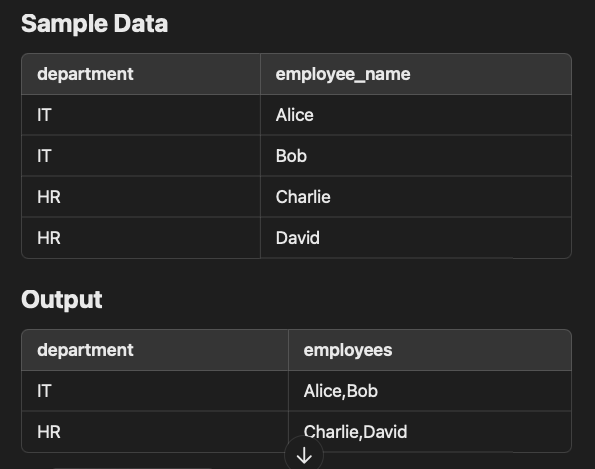
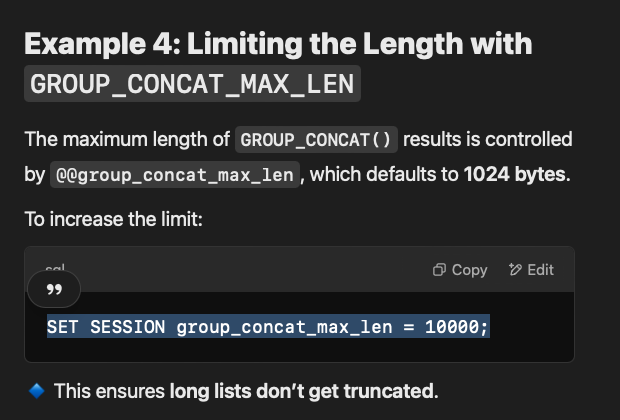

# SPOTIFY DATALEMUR QUESTION

https://datalemur.com/questions/top-fans-rank

1. Learned that we don't have to use partition by when using rank window funtions we cna just use order by in the OVER clause

2. We can use the COUNT() Aggregation function in SQL in Window Funtion. But we have to use the GROUP BY function.

3. WHenever we use an aggregate funtion we must use the group by clause


In [ ]:
-- Identify 10 Artists whose songs appeared the most in the glabal rankings table
WITH artists_songs AS (

  SELECT 
        a.artist_name,
        DENSE_RANK() OVER(ORDER BY COUNT(s.song_id) DESC) AS artist_rank
  FROM artists AS a
  
  INNER JOIN songs AS s
  ON a.artist_id = s.artist_id
  
  INNER JOIN global_song_rank as gs 
  ON s.song_id = gs.song_id
  
  WHERE rank <= 10
  GROUP BY a.artist_name
)

-- Filter for top 5 artists whose songs appeared the most
SELECT artist_name, artist_rank
FROM artists_songs
WHERE artist_rank <= 5;

## Bloomberg FAANG STOCKS

In [ ]:
-- MY Solution
-- Identify rows with lowest and highest open
WITH cte AS (
  SELECT
    ticker,
    TO_CHAR(date, 'Mon-YYYY') AS month,
    open,
    -- Identify Row with Highest Open
    ROW_NUMBER() OVER(PARTITION BY ticker ORDER BY open DESC) as highest_open,
    -- Identify row with Lowest Open
    ROW_NUMBER() OVER(PARTITION BY ticker ORDER BY open ASC) AS lowest_open
FROM stock_prices
ORDER BY ticker ASC, highest_open ASC

)

-- SElF JOIN cte to have Highest month & highest open price and lowest month & lowest price on the same row
SELECT
  t1.ticker AS ticker,
  t1.month AS highest_month,
  t1.open AS highest_open,
  t2.month AS lowest_month,
  t2.open AS lowest_open
  
FROM cte AS t1
JOIN cte AS t2

ON t1.ticker = t2.ticker
  AND t1.highest_open = 1 -- filter for rows in t1 that have the highest open price
  AND t2.lowest_open = 1 -- -- filter for rows in t1 that have the lowest open price
  
ORDER BY ticker ASC;

## Learnings

1. When using an aggregate function I must use the GROUP BY clause

2. WE can use the ORDER BY with ranking window functions. For exmaple, we get the name of the top sales agent within each Branch of best buy in Ottawa.
    ROW_NUMBER(PARTITION BY branch_id ORDER BY sales_closed DESD) AS top_sales person

3. We can get the top sales and bottoem sales person from the same table using ranking window functions and a self-join

    ROW_NUMBER(PARTITION BY branch_id ORDER BY sales_closed DESC) AS top_sales_person
        - The row with the top sales person will have a rank of one
    ROW_NUMBER(PARTITION BY branch_id ORDER BY sales_closed ASC) AS bottom_sales_person
        - The row with the top sales person will have a rank of one

    The we can use a sefl-join on the same table filtering for row in table 1 that has the top_sales_person = 1;
    then filter for row in table 2 that has the bottom_sales_person = 1


# Datalemur User Shopping sprees

https://datalemur.com/questions/amazon-shopping-spree

In [ ]:
-- Create a column with transactions of the follwing day
WITH cte AS (
    SELECT
    *,
    LEAD(transaction_date) OVER(PARTITION BY user_id ORDER BY transaction_date) AS next_day_transaction
  FROM transactions
  ORDER BY user_id
),

-- Subtract next_day_transaction from transaction date to filter fro consecutive days
 cte2 AS (
   SELECT 
    *,
    EXTRACT(DAY FROM next_day_transaction - transaction_date) AS consec_days
  FROM cte
),

-- Filter for consecutive days only
cte3 AS (
  SELECT *
  FROM cte2
  WHERE consec_days = 1
)

-- Filter for uses who had shopping sprees of lasting 3 days or more
SELECT
    user_id
FROM cte3
GROUP BY user_id
HAVING SUM(consec_days) >= 2


In [ ]:
-- Datalemur Solution

SELECT *

FROM transactions AS t1 -- original table

-- Filter for users that had one consecutive day of shopping
INNER JOIN transactions AS t2
  ON DATE(t2.transaction_date) = DATE(t1.transaction_date) + 1
  -- We are joining on transaction_date because we can know if
  -- a user had a consecutive day of shopping by seeing self-joining
  -- the transaction table and seeing if a date from t2 is one 
  -- day ahead of a date from t2

INNER JOIN transactions AS t3
  ON DATE(t3.transaction_date) = DATE(t1.transaction_date) + 2
  
ORDER BY T1.user_id

## Learnings

#### Self-Joins are an alternative to window functions for getting the data you need on the same row for each user.

#### Use the DATE() function to convert date text into DATE TIMESTAMP

#### You can join on other conditions not just user_id removing the requirement for WHERE clause 

# TikTok interview Question

In [ ]:
-- Join the Emails and Texts Table with Left join
-- Left Join because we on want activation rate of users in the email tables
WITH emails_texts AS (
  SELECT
    e.email_id, e.user_id, e.signup_date, t.text_id, t.signup_action
  FROM emails as e 
  LEFT JOIN texts as t 
  ON e.email_id = t.email_id
)

SELECT
  ROUND(SUM(CASE WHEN signup_action = 'Confirmed' THEN 1 ELSE 0 END) :: decimal/COUNT(email_id),2) AS confirmation_rate
FROM emails_texts
WHERE text_id is NOT NULL -- Filters for users who recieve confirmation text

### Learnings

1. When we divide by an integer in SQL sometimes we will get a a result of Zero. To resolve this Cast the Numerator or denominator as a Decimal

2. I can use the ON condition to filter for rows instead of using the WHERE clause.

## Supercloud Customer

In [ ]:
-- Join Customer and products table to get product categories in the same rows as product id 
WITH cust_prod AS (
  SELECT *
  FROM customer_contracts AS cc 
  LEFT JOIN products AS p 
    ON cc.product_id = p.product_id
)


SELECT 
  customer_id
FROM cust_prod
GROUP BY customer_id 
HAVING COUNT(DISTINCT product_category) = (SELECT COUNT(DISTINCT product_category) FROM products) -- Check if each customer bought at least one product from each product category.
ORDER BY customer_id

Learnings

1. use the HAVING keyword to filer Groups after using GROUP BY clause.

2. When you need to filter output after using GROUP BY use subqueries.
    For example 
    Suppose you had two tables

    One table is called active_users - conntaining users that have opened the app at least 5 times a month
    The is dormant_users - containing users that only use the app less than 10 times every 6 months.

    You ar now tasks with the finding what percetage of users are active.

    To find this percentage You use subquery in SELECT To count the number of dormant users from the other table and add it to the number of active users

3. You can count the total number of rows using window functions COUNT(*) OVER() AS total_rows

# Google SQL  Interview Questions - Odd and Even measurements

https://datalemur.com/questions/odd-even-measurements

In [ ]:
-- MY Solution

WITH batch_measurements AS (
  SELECT
    *,
    DATE_TRUNC('day', DATE(measurement_time)) as measurement_day,
    ROW_NUMBER() 
      OVER(PARTITION BY DATE_TRUNC('DAY', measurement_time) ORDER BY measurement_time) AS day_groups
  FROM measurements
)


SELECT 
 measurement_day,
 SUM(CASE WHEN day_groups IN (1,3,5) THEN measurement_value ELSE 0 END) AS odd_sum,
 SUM(CASE WHEN day_groups IN (2,4,6) THEN measurement_value ELSE 0 END) AS even_sum
FROM batch_measurements
GROUP BY measurement_day
ORDER BY measurement_day

## Learnings

1. DATE_TRUNC() can be used to truncate dates like this '07/10/2022 09:00:00' to '07/10/2022 00:00:00'
    DATE_TRUNC('day', '07/10/2022 09:00:00') -> '07/10/2022 00:00:00'
    Removes the hour, minute and second component of a date but leaves day, month, year intaact

2. We USE the FLOOR() function combined with window functions to group rows in to batches
    E.g.
    FLOOR( (ROW_NUMBER() OVER(ORDER BY meaurement_day) - 1) / 6) + 1 

    This code resets after every 6 rows.

    

# Swapped Food delivery

In [ ]:
-- Find max order ID
WITH max_order AS (
  SELECT MAX(order_id) AS max_order_id
  FROM orders
),

-- Create corrected_order_id
cte AS (
 SELECT 
    *,
    CASE
      WHEN order_id NOT IN (SELECT(max_order_id) FROM max_order) THEN  -- Leave maximum order id alone
        CASE
          WHEN order_id % 2 = 0 THEN order_id - 1
          ELSE order_id + 1 
        END 
      ELSE order_id
    END AS corrected_order_id
 FROM orders

)

SELECT corrected_order_id,item 
FROM cte
ORDER BY corrected_order_id

# Verizon Question

In [ ]:
https://datalemur.com/questions/international-call-percentage

In [ ]:
-- My solution

-- Count number of calls
WITH num_total_calls AS (
  SELECT COUNT(*) AS number_of_calls
  FROM phone_calls
),

-- Get the country of callers andf recievers on the same row
phone_call_info AS (

  SELECT 
    pc.caller_id AS pc_caller_id, 
    pc.receiver_id AS pc_receiver_id,
    pi1.country_id AS caller_country,
    pi2.country_id AS receiver_country,
    COUNT(*) OVER() AS call_count
  FROM phone_calls AS pc 
  
  INNER JOIN phone_info AS pi1
   ON pc.caller_id = pi1.caller_id
   
  INNER JOIN phone_info AS pi2 
    ON pc.receiver_id = pi2.caller_id
),

-- Count the number of international calls
num_international_calls AS (
  SELECT COUNT(*) AS int_calls
  FROM phone_call_info
  WHERE caller_country <> receiver_country
)

--  Calculate percentage of international calls
SELECT 
  ROUND((ic.int_calls::DECIMAL / tc.number_of_calls) * 100, 1) 
  AS international_calls_pct
FROM num_international_calls ic, num_total_calls tc;


### Learnings

In [ ]:
1. WHEN dividing two integers and rounding the result with the ROUND() fucntion, SQL returns an error.
The solution is to cast the numerator or denominator as DECIMAL or FLOAT so that the ROUND function can ROUND.

2 The player_id column in the other phone_ifo table contained id's of callers (The people who made the call)
and id's of receivers (The person who recieves a call from the caller). This was problematic because joining thes
two table USING

  INNER JOIN phone_info AS pi1
   ON pc.caller_id = pi1.caller_id OR  pc.caller_id = pi1.receiver_id

Just reslulted in duplicate rows.


In [ ]:

The solution is to use a seperate INNER JOIN. One INNER JOIN for caller_id and another join for reciever ID

DATALEMUR ALIBABA QUESTION

I didn;t solve this question on my own because i didn;t understand the question

In [ ]:
WITH mode AS (
  SELECT MODE() WITHIN GROUP (ORDER BY order_occurrences) as mode_occurence
  FROM items_per_order
)

SELECT item_count
FROM items_per_order
WHERE order_occurrences = (SELECT mode_occurence FROM mode)

### New learnings

1. Learned to use MODE() WITHIN GROUP  to find the mode within a column